# Introduction


In this notebook I am working on applying the Gauss-Siedel 1D MP-Iteration to Gerry's problem with a Hessian Mesh Density function (extra alpha_tilda solve). The goal is to show that this produces the same reuslt as I get in the notebook: **MyMPIter_June2025.ipynb** where I use my own MP-Iteration code to perform the MP-Iteration.

In comparing the values of alpha, the meshes, and the physical solutions that both notebooks produce, It appears as though their results match!

June 2025

# Imports

In [ ]:
# install firedrake

# hide output
%%capture

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake

try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [ ]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

# The MP Solver

In [ ]:
# Class for the MP solver.
from firedrake.dmhooks import get_appctx, get_function_space


class GaussSeidelSNES(SNESBase):
    prefix = "gs_"

    def initialize(self, snes):
        ctx = get_appctx(snes.dm)
        W = get_function_space(snes.dm)
        self.sol = ctx._problem.u_restrict
        split_ctxs = ctx.split([(i,) for i in range(len(W))])
        full_prefix = snes.getOptionsPrefix() + self.prefix
        for i, ctx in enumerate(split_ctxs):
            NonlinearVariationalSolver(
                ctx._problem, options_prefix=full_prefix+str(i))
        self.solvers = tuple(
            NonlinearVariationalSolver(
                ctx._problem, options_prefix=full_prefix+str(i))
            for i, ctx in enumerate(split_ctxs)
        )

    def update(self, snes):
        pass

    def step(self, snes, x, f, y):
        with self.sol.dat.vec_wo as vec:
            x.copy(vec)

        solve_count = 1

        for solver, u in zip(self.solvers, self.sol.subfunctions):

            print('Solver Counter = ', solve_count)
            print()
            print()
            solve_count += 1


            solver._problem.u_restrict.assign(u)
            solver.solve()
            u.assign(solver._problem.u_restrict)


        # self.sol.subfunctions[-1].dat.data[0:3]

        print()
        print("alpha value is %e" % (float(self.sol.subfunctions[-1])))
        print()

        print()
        print('First three x values:', self.sol.subfunctions[0].dat.data[0:3])
        print()



        with self.sol.dat.vec_ro as vec:
            vec.copy(y)
            y.aypx(-1, x)
        snes.setConvergedReason(self.solvers[0].snes.reason)

In [ ]:
from firedrake.preconditioners.base import SNESBase
from firedrake.petsc import PETSc
from firedrake.dmhooks import get_appctx, get_function_space
from firedrake.function import Function



__all__ = ("FieldsplitSNES",)


class FieldsplitSNES(SNESBase):
    prefix = "fieldsplit_"

    # TODO:
    #   - Allow setting field grouping/ordering like fieldsplit

    @PETSc.Log.EventDecorator()
    def initialize(self, snes):
        from firedrake.variational_solver import NonlinearVariationalSolver  # ImportError if we do this at file level
        ctx = get_appctx(snes.dm)
        W = get_function_space(snes.dm)
        self.sol = ctx._problem.u_restrict

        # buffer to save solution to outer problem during solve
        self.sol_outer = Function(self.sol.function_space())

        # buffers for shuffling solutions during solve
        self.sol_current = Function(self.sol.function_space())
        self.sol_new = Function(self.sol.function_space())

        # options for setting up the fieldsplit
        snes_prefix = snes.getOptionsPrefix() + 'snes_' + self.prefix
        # options for each field
        sub_prefix = snes.getOptionsPrefix() + self.prefix

        snes_options = PETSc.Options(snes_prefix)
        self.fieldsplit_type = snes_options.getString('type', 'additive')
        if self.fieldsplit_type not in ('additive', 'multiplicative'):
            raise ValueError(
                'FieldsplitSNES option snes_fieldsplit_type must be'
                ' "additive" or "multiplicative"')

        split_ctxs = ctx.split([(i,) for i in range(len(W))])

        self.solvers = tuple(
            NonlinearVariationalSolver(
                ctx._problem, appctx=ctx.appctx,
                options_prefix=sub_prefix+str(i))
            for i, ctx in enumerate(split_ctxs)
        )

    def update(self, snes):
        pass

    @PETSc.Log.EventDecorator()
    def step(self, snes, x, f, y):
        # store current value of outer solution
        self.sol_outer.assign(self.sol)

        # the full form in ctx now has the most up to date solution
        with self.sol_current.dat.vec_wo as vec:
            x.copy(vec)
        self.sol.assign(self.sol_current)

        # The current snes solution x is held in sol_current, and we
        # will place the new solution in sol_new.
        # The solvers evaluate forms containing sol, so for each
        # splitting type sol needs to hold:
        #   - additive: all fields need to hold sol_current values
        #   - multiplicative: fields need to hold sol_current before
        #       they are are solved for, and keep the updated sol_new
        #       values afterwards.


        solver_count = 0
        solver_list = ["mesh solve", "physical solve", "mesh update", "alpha solve"]
        print()
        print()
        print()
        print()
        print("MP ITERATION")
        print('_'*50)
        print()


        for solver, u, ucurr, unew in zip(self.solvers,
                                          self.sol.subfunctions,
                                          self.sol_current.subfunctions,
                                          self.sol_new.subfunctions):
            print(solver_list[solver_count])
            solver_count += 1
            print()

            solver.solve()
            unew.assign(u)
            if self.fieldsplit_type == 'additive':
                u.assign(ucurr)


        print("alpha value is %e" % (float(self.sol.subfunctions[-1])))
        print()


        # plot our mesh
        x_curr = self.sol.subfunctions[0]
        perm_curr = np.argsort(x_curr.dat.data[:])
        plt.plot(x_curr.dat.data[:], np.zeros_like(x_curr.dat.data[:]), marker = "|")
        plt.title("Current Mesh")
        plt.xlabel("x mesh")
        plt.ylabel("0")
        plt.show()
        print()
        print()



        # plot our mesh spacing
        print()
        print()
        plt.plot(np.diff(x_curr.dat.data[perm_curr])[-25:], label = "My Mesh Last 25 h's")
        plt.plot(np.diff(x_curr.dat.data[perm_curr])[0:25], label = "My Mesh First 25 h's")
        plt.title("The first and last 25 mesh spacings")
        plt.xlabel("Mesh index")
        plt.ylabel("h")
        plt.legend()
        plt.show()
        print()
        print()

        with self.sol_new.dat.vec_ro as vec:
            vec.copy(y)
            y.aypx(-1, x)

        # restore outer solution
        self.sol.assign(self.sol_outer)

# Gerry's Example with m = 0

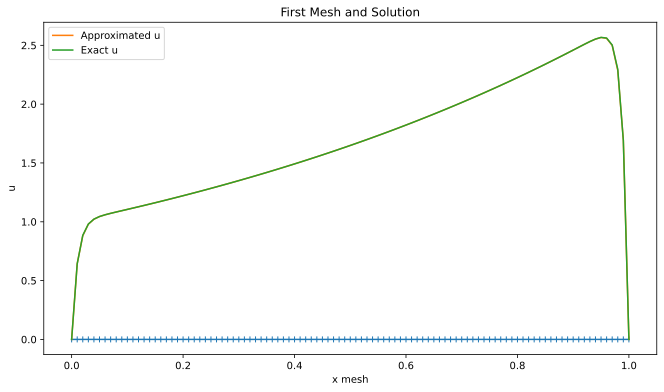




starting alpha_tilda is 7.5601806640625






MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.510119e+00



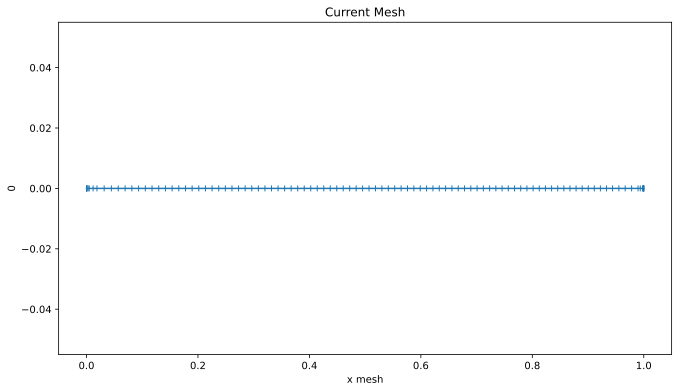

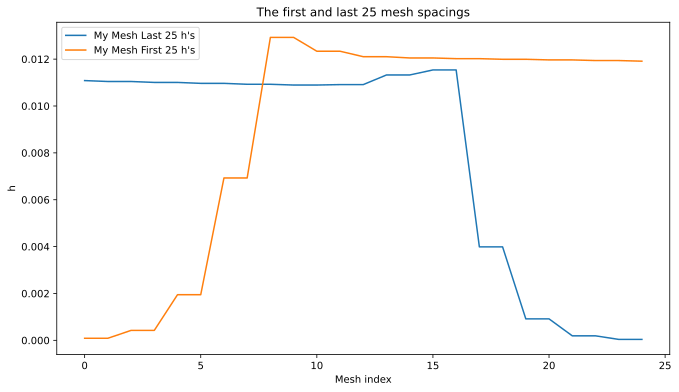



  0 SNES Function norm 3.026951023046e+02
  1 SNES Function norm 1.987141438918e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.585379e+00



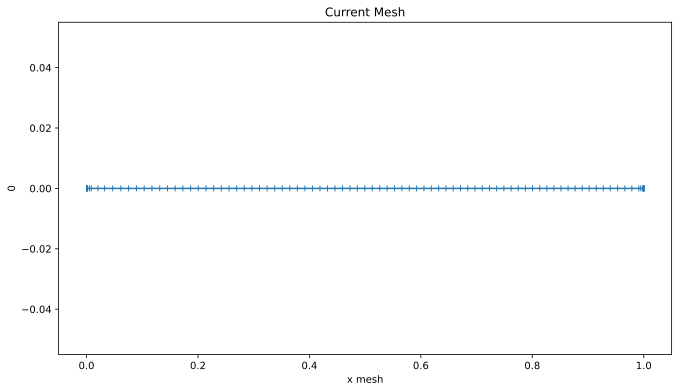

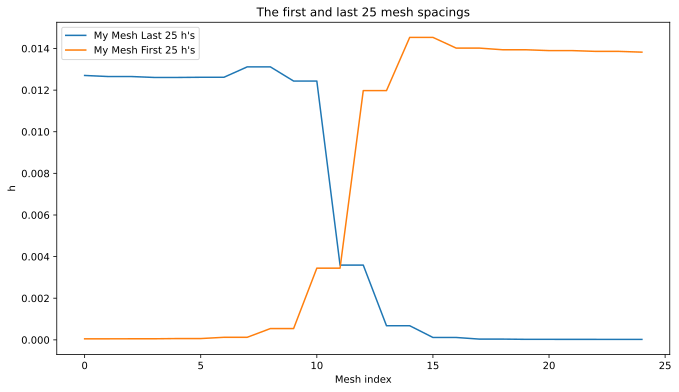



  2 SNES Function norm 2.171771496040e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.860303e+00



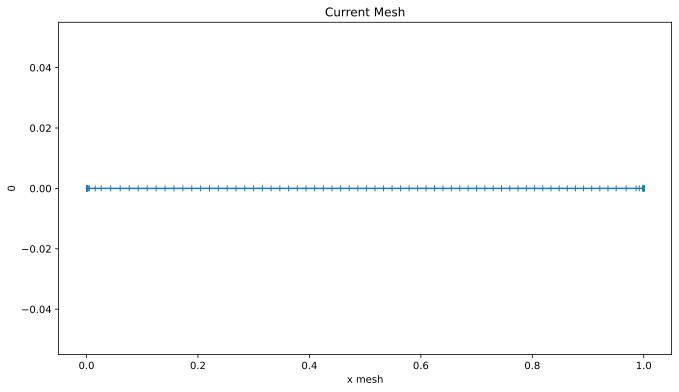

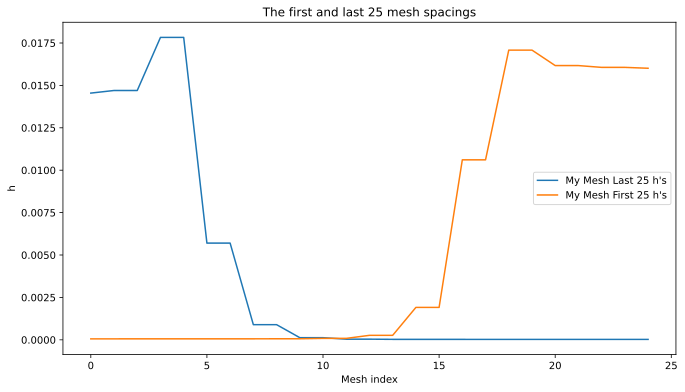



  3 SNES Function norm 2.361455577449e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.926936e+00



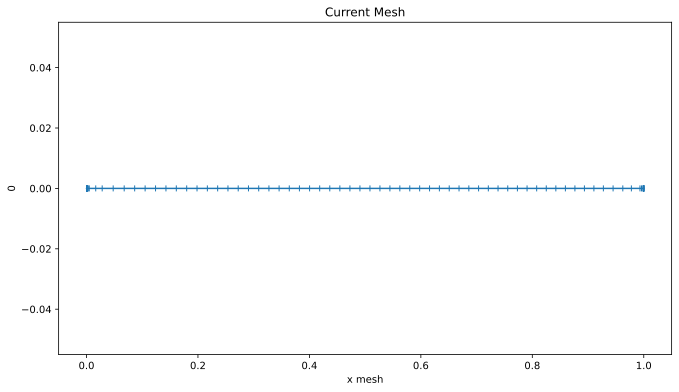

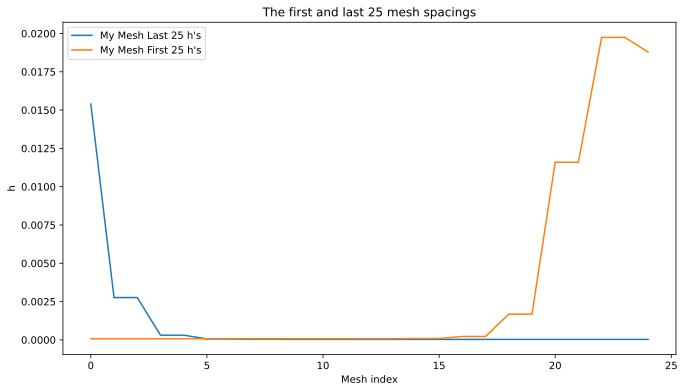



  4 SNES Function norm 2.598963636796e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 8.053038e+00



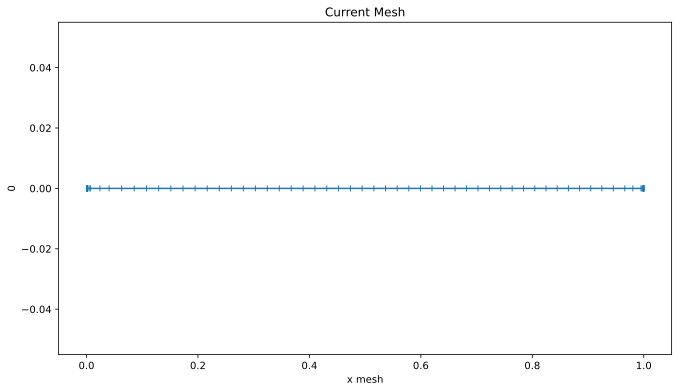

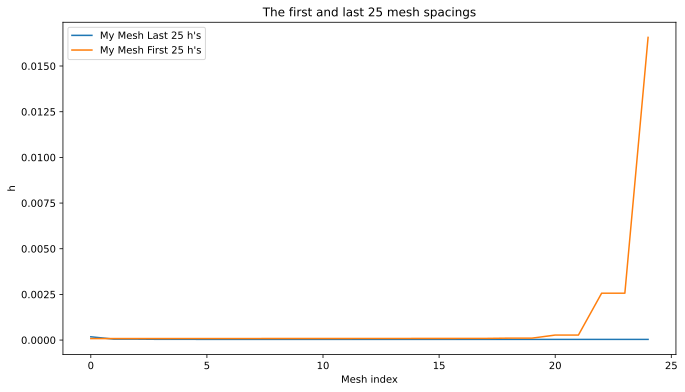



  5 SNES Function norm 2.857977349734e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 8.370254e+00



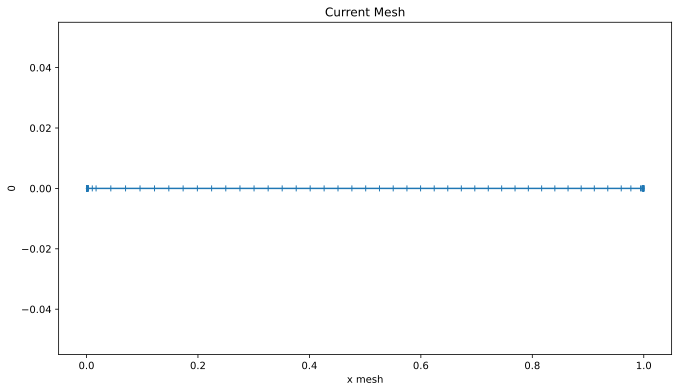

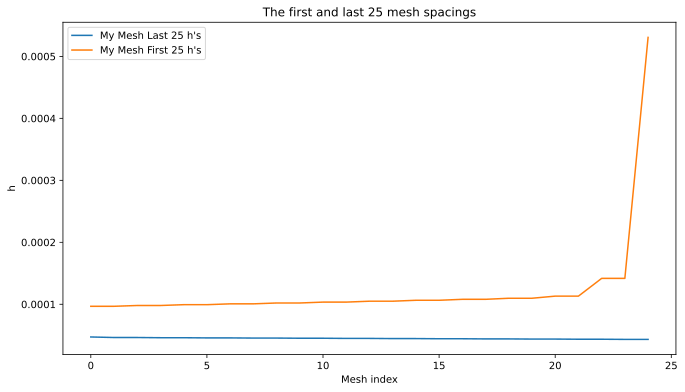



  6 SNES Function norm 2.680005871736e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 8.729356e+00



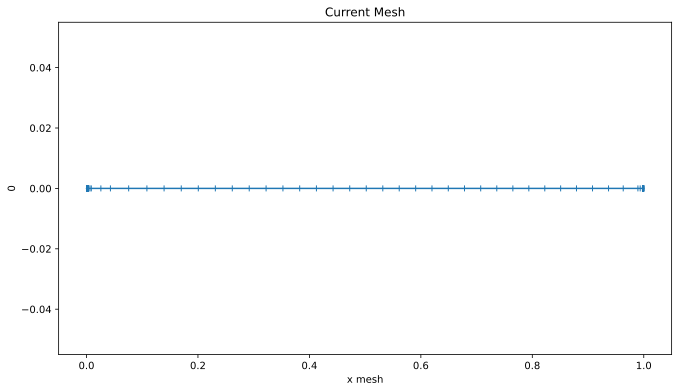

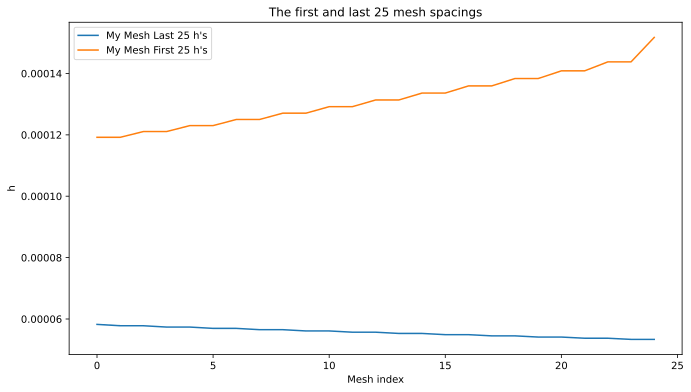



  7 SNES Function norm 2.056104220029e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 8.254202e+00



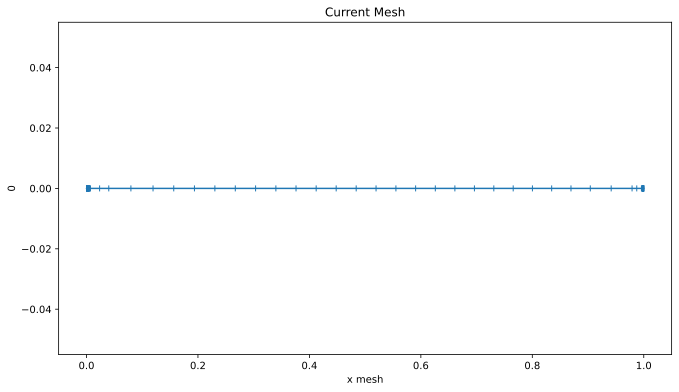

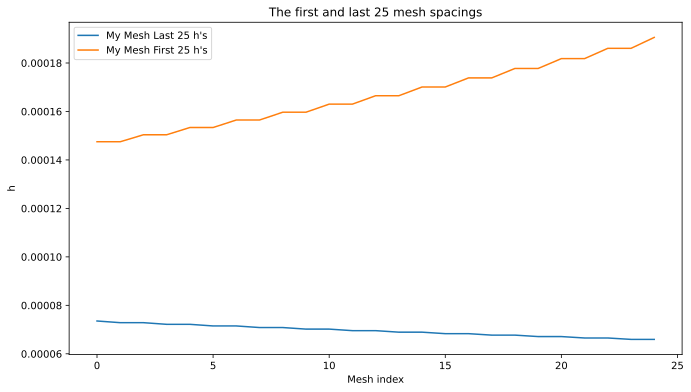



  8 SNES Function norm 2.594696071098e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.701682e+00



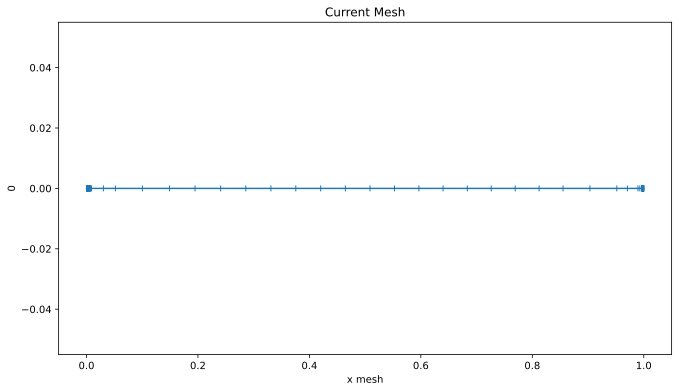

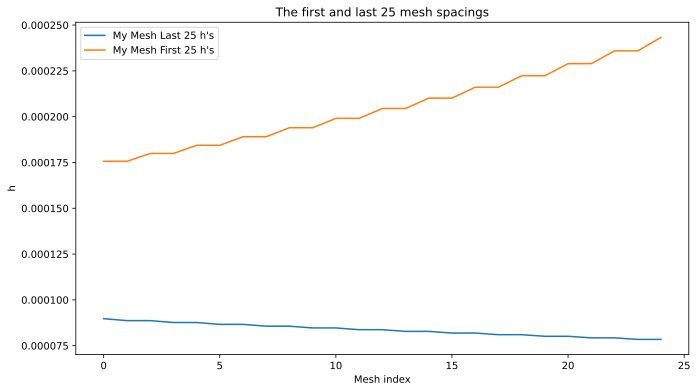



  9 SNES Function norm 2.192538566342e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 8.644440e+00



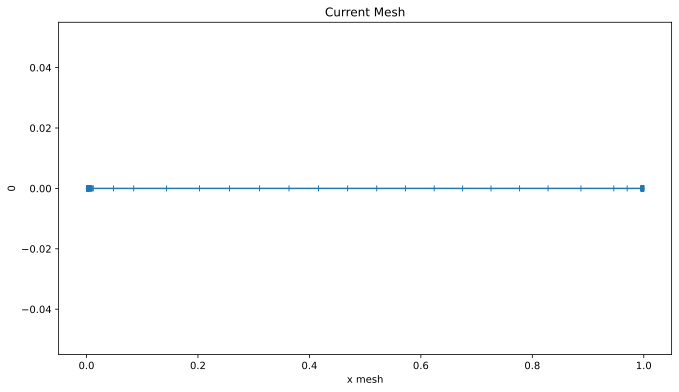

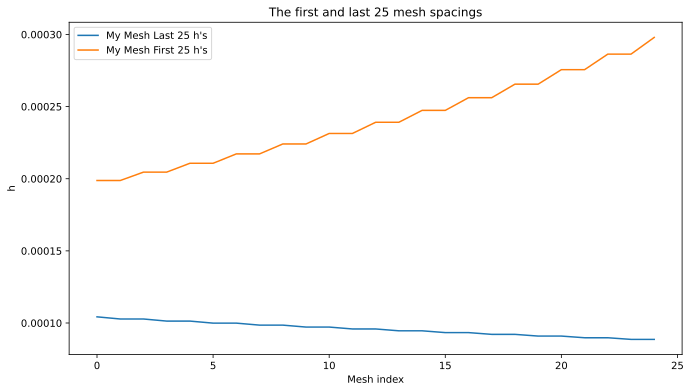



 10 SNES Function norm 2.728890378874e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.966848e+00



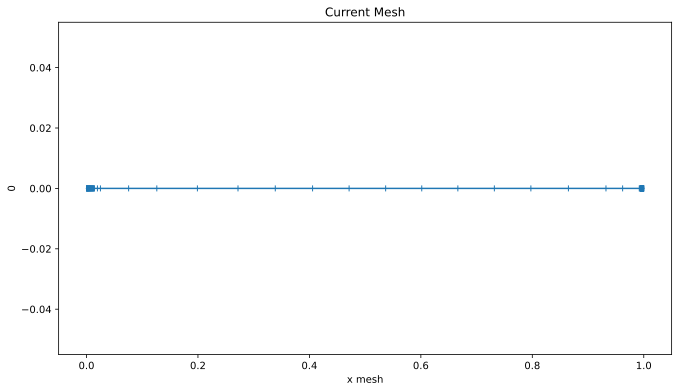

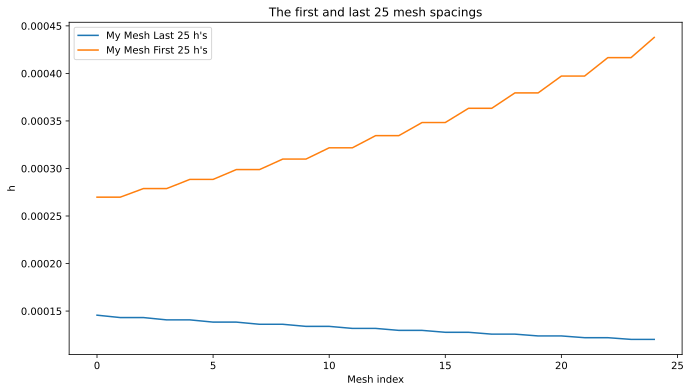



 11 SNES Function norm 2.211415101360e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.970736e+00



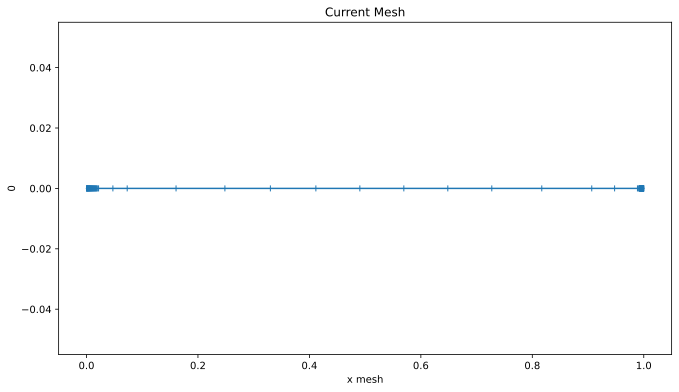

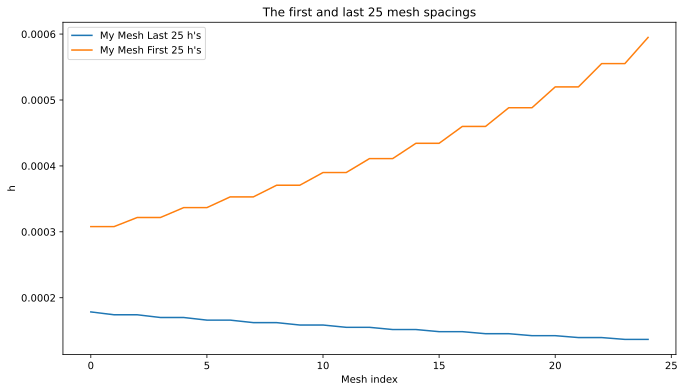



 12 SNES Function norm 1.343966359548e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 6.559509e+00



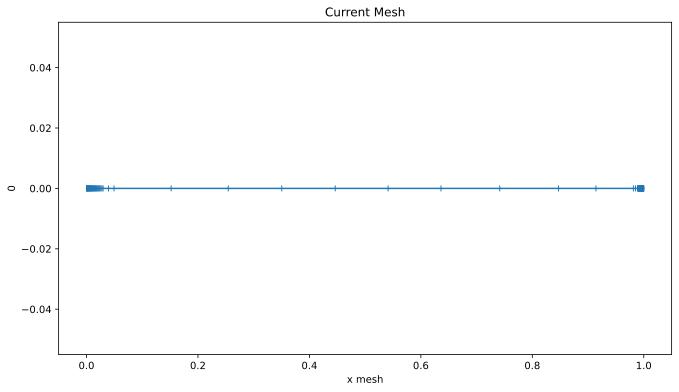

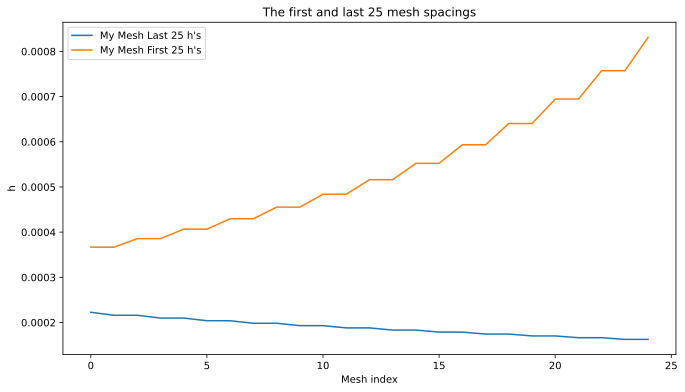



 13 SNES Function norm 8.529629171036e+01




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 6.131578e+00



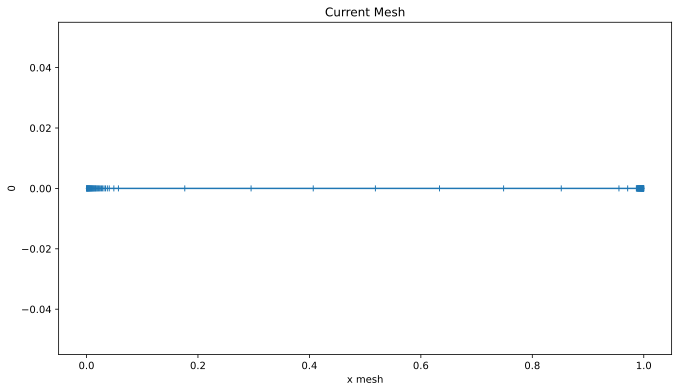

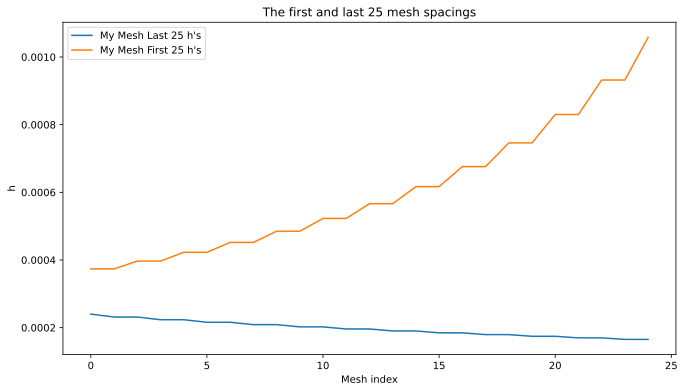



 14 SNES Function norm 1.932907087194e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 6.149437e+00



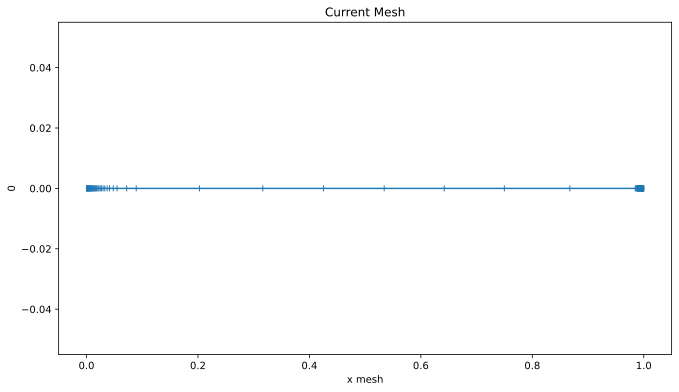

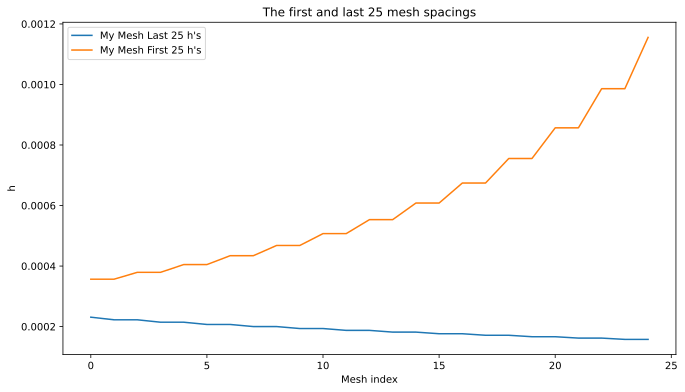



 15 SNES Function norm 4.316116513840e+01




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.448024e+00



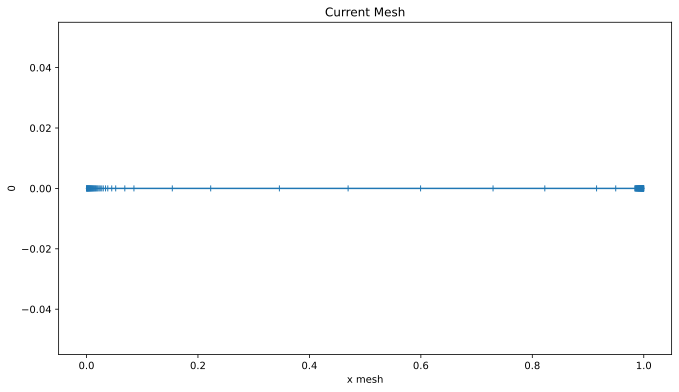

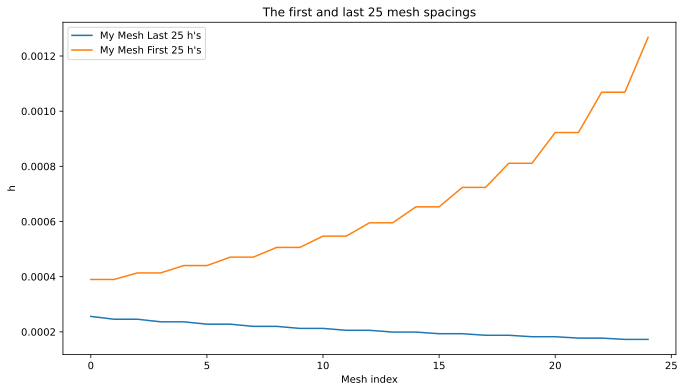



 16 SNES Function norm 1.133944717544e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 6.004515e+00



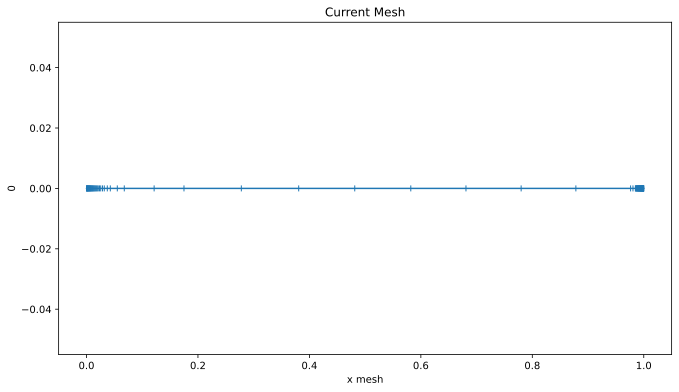

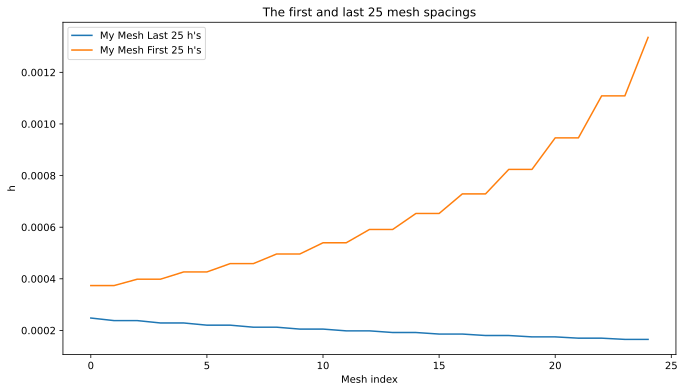



 17 SNES Function norm 6.598208366381e+01




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 7.500227e+00



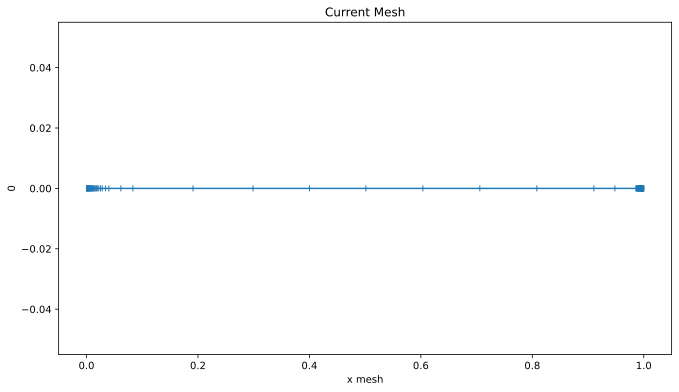

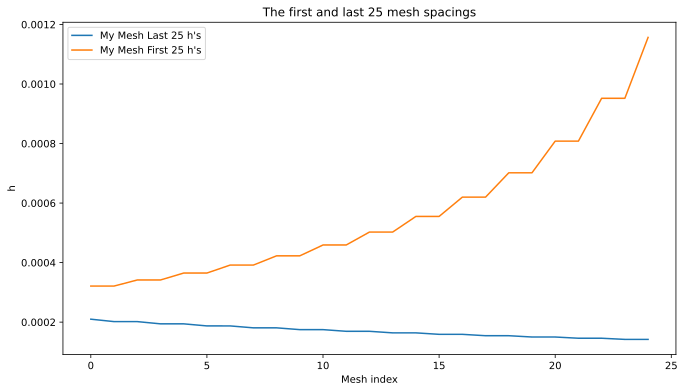



 18 SNES Function norm 1.238733659222e+02




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 5.718710e+00



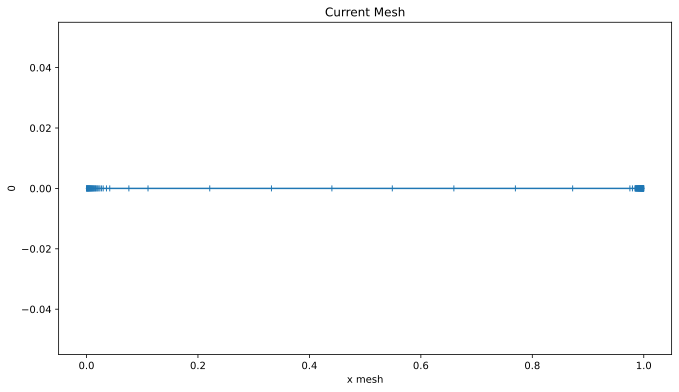

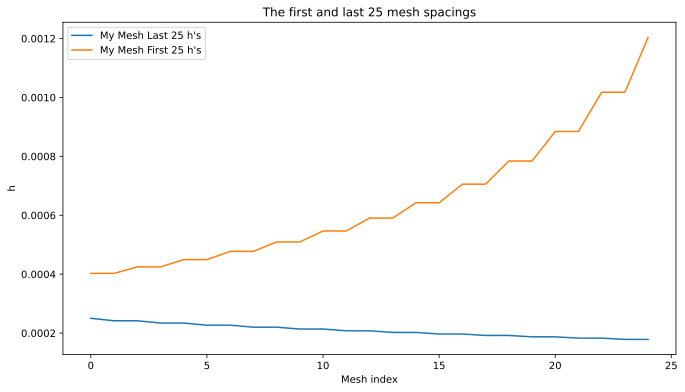



 19 SNES Function norm 7.111305325980e+01




MP ITERATION
__________________________________________________

mesh solve

physical solve

mesh update

alpha solve

alpha value is 6.651124e+00



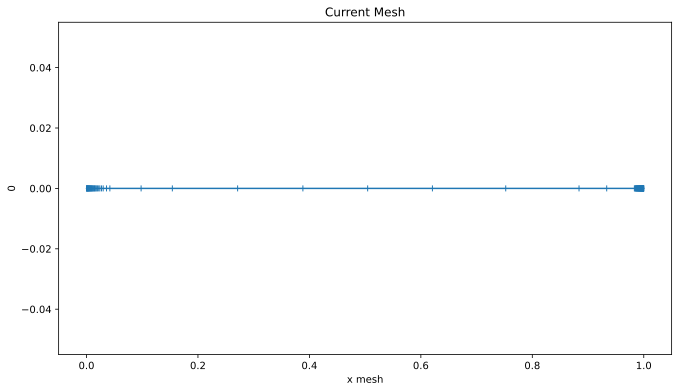

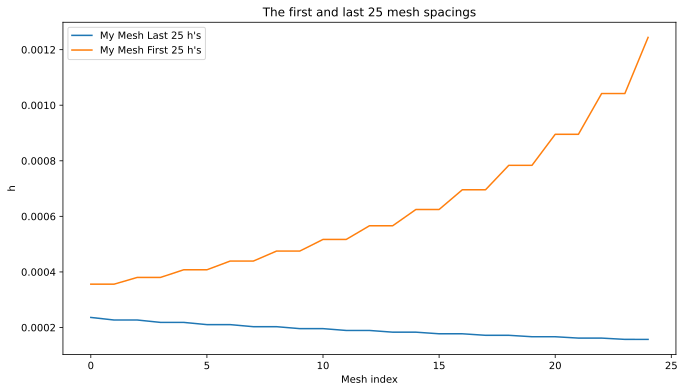



 20 SNES Function norm 8.717957683449e+01


Solver failed because of the following message:
Nonlinear solve failed to converge after 20 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT



In [ ]:
# SETUP
#################################################

# Grid size and epsilon
N = 50
epsilon = Constant(0.01)

# Set our parameters for the hessian mesh density
# d = 1
p = Constant(2)
q = Constant(2)
m = Constant(0)
alpha_hat = Constant(1)
exp_M = (2*q) / (1 + q*(2-m))
exp_rho = exp_M / 2

# Initialize uniform mesh for xi
xi_mesh = UnitIntervalMesh(N)
xi_coord = SpatialCoordinate(xi_mesh)[0]


# print('mesh:', xi_mesh.coordinates.dat.data[:])
# print()



# Our function spaces
V = FunctionSpace(xi_mesh, "CG", 2)
V_alpha = FunctionSpace(xi_mesh, "R", 0)

# Set initial x(xi) to be uniform grid
x = Function(V)
x.interpolate(xi_coord)

# Set exact solution
top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x)/(epsilon**2 - 1)
u_exact = top/bottom - sub





# FIRST PHYSICAL SOLVE
#######################################################

# Set test and trial functions
u = TrialFunction(V)
v = TestFunction(V)

# Set the bilinear and linear forms of the weak form
Jx = x.dx(0) #dx/dxi
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

# Set the BC's
#bcs = [DirichletBC(V, u_exact(0), 1), DirichletBC(V, u_exact(1), 2)]
bcs = [DirichletBC(V, Constant(0), 1), DirichletBC(V, Constant(0), 2)]
# Solve

u = Function(V)
solve(a==L, u, bcs = bcs)


permute_x = np.argsort(x.dat.data[:])

plt.plot(x.dat.data[permute_x], np.zeros_like(x.dat.data[permute_x]), marker = "|")
plt.plot(x.dat.data[permute_x], u.dat.data[permute_x], label = "Approximated u")
plt.plot(x.dat.data[permute_x], Function(V).interpolate(u_exact).dat.data[permute_x], label = "Exact u")
plt.title("First Mesh and Solution")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()

print()
print()
print()






# FIND AN INITIAL ALPHA TILDA
#####################################################


# Find second derivative of u w.r.t x

# compute the derivatives of our u
u_pr = u.dx(0)
u_prpr = u_pr.dx(0)
x_prpr = Jx.dx(0)
du_dx = (1/Jx) * u_pr
du2_dx2 = ( u_prpr -  du_dx * x_prpr) * (( 1/Jx )**2)

# Set the RHS of the rho problem: 2*C_t
RHS = float(2.0) # 2*C_t evaluates to 2 for p=q=2 and m = 0,1

# Set an initial bisection interval as (a1=0, a2=0) to be updated
alpha1 = 0
alpha2 = 0

# Set our initial guess for alpha_tilda to be 1.0
alpha3 = 1.0

# Stopping criteria
maxit_alpha = 1000
iter = 0


# Loop to find search interval for alpha
while ((iter <= maxit_alpha) and (alpha1==0 or alpha2==0)) :

    iter += 1

    # Compute LHS as integral of rho
    inside_bit = 1 + (1/alpha3) * abs(du2_dx2)
    rho = inside_bit ** (exp_rho)
    LHS = float(assemble(rho * Jx * dx))

    # check is alpha guess is too small. If so, make it left endpoint and increase size
    if LHS > RHS:
      alpha1 = alpha3
      alpha3 = 2*alpha1

    # if alpha guess to too big, make it right endpoint and decrease size
    else:
      alpha2 = alpha3
      alpha3 = alpha2/2


# Hopefully we have (alpha1, alpha2) search interval. Lets check
if (alpha1==0 and alpha2==0):
  print("WARNING WE DID NOT FIND A SEARCH INTERVAL FOR ALPHA")
  print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


# Now we do bisection in this search interval to find alpha tilda
alpha3 = (alpha1 + alpha2)/2
inside_bit = 1 + (1/alpha3) * abs(du2_dx2)
rho = inside_bit ** (exp_rho)
LHS = float(assemble(rho * Jx * dx))
iter = 0

while ( (iter <= maxit_alpha) and ( abs(LHS - RHS) > 1e-6 )):

  iter += 1

  if (LHS - RHS) > 0:
    alpha1 = alpha3

  else:
    alpha2 = alpha3

  # update alpha3 as new midpoint
  alpha3 = (alpha1 + alpha2)/2

  # Update our LHS
  inside_bit = 1 + (1/alpha3) * abs(du2_dx2)
  rho = inside_bit ** (exp_rho)
  LHS = float(assemble(rho * Jx * dx))



# Did we find our alpha tilda??
if iter == maxit_alpha:
  print("WARNING WE DID NOT FIND AN ALPHA TILDA UNDER MAXITS")
  print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


# Set alpha tilda to be the final alpha3
alpha_tilda = alpha3



print("starting alpha_tilda is", alpha_tilda)
print()
print()







# SET UP FOR MP ITERATION
##############################################


W = V*V*V*V_alpha
xuxa = Function(W)
yvyb = TestFunction(W)

# set our initial guesses
xuxa.sub(0).interpolate(x)
xuxa.sub(1).interpolate(u)
xuxa.sub(2).interpolate(x)
xuxa.sub(3).interpolate(alpha_tilda)







# MP ITERATION
################################################


# Retrieve our functions
x,u, x_old, alpha_tilda = split(xuxa)
y,v, y_old, a_test = split(yvyb)

# x_old jacobian
jacobx = x_old.dx(0) #dx/dxi

# compute the derivatives of our u
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)


# compute the Hessian M using computed alpha tilda

# Compute alpha using alpha tilda
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Now compute M
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_lin = inside_bit_lin ** (exp_M)



# jacobian based on current x
Jm = x.dx(0) #dx/dxi


# Physical PDE
u_deriv = (1/Jm) * u.dx(0) # transform to du/dx
v_deriv = (1/Jm) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jm * dx # transform dxi to dx
L = ( exp(x) ) * v * Jm * dx #transform dxi to dx


# y' where y is test for x
y_pr_term = y.dx(0)


# Now our alpha_tilda equation

Jm = x.dx(0)
u_pr = u.dx(0)
du_dx = (1/Jm) * u_pr # transform to du/dx
u_prpr = (u_pr).dx(0)
x_prpr = Jm.dx(0)
du2_dx2 = ( u_prpr -  du_dx * x_prpr) * (( 1/Jm )**2)

inside_bit = 1 + (1/alpha_tilda) * abs(du2_dx2)
rho = inside_bit ** (exp_rho)
a_rho = inner(rho * Jm, a_test) * dx
L_rho = inner(RHS, a_test) * dx


# Total form
F = (M_lin * Jm * y_pr_term)*dx + (a - L) + (x-x_old)*y_old*dx + (a_rho - L_rho)




# bc's
bcx0 = DirichletBC(W.sub(0), Constant(0), 1)
bcx1 = DirichletBC(W.sub(0), Constant(1), 2)
bcu0 = DirichletBC(W.sub(1), Constant(0), 1)
bcu1 = DirichletBC(W.sub(1), Constant(0), 2)
bcs = [bcx0, bcx1, bcu0, bcu1]



# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}


newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'mat_type': 'nest'
}


GS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.GaussSeidelSNES',
    'snes_linesearch_type': 'basic',
    'snes_linesearch_monitor': None,
    'snes_linesearch_damping': 0.5,
    'npc_gs_0': lu_params,
    'npc_gs_1': lu_params,
    'npc_gs_2': lu_params,
    'npc_gs_3': newton_params,
    'snes_max_it': 20,
    'snes_rtol': 1e-12,
    'snes_atol': 1e-50,
    'snes_stol': 1e-12,
}



FS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.FieldsplitSNES',
    'npc_snes_fieldsplit_type': "multiplicative",
    'snes_linesearch_type': 'basic',
    'snes_linesearch_monitor': None,
    # 'snes_linesearch_damping': 0.5,
    'npc_snes_fieldsplit_0': mesh_params,
    'npc_snes_fieldsplit_1': lu_params,
    'npc_snes_fieldsplit_2': lu_params,
    'npc_snes_fieldsplit_3': newton_params,
    'snes_max_it': 20,
    'snes_rtol': 1e-12,
    'snes_atol': 1e-50,
    'snes_stol': 1e-12,
}




# solve the problem

try:
  NLVP = NonlinearVariationalProblem(F, xuxa, bcs=bcs)
  NLVS = NonlinearVariationalSolver(NLVP, solver_parameters=FS_params)
  NLVS.solve()
except Exception as e:
  print()
  print()
  print('Solver failed because of the following message:')
  print(e)
  print()

# Save our progress
x, u, x_old, alpha_tilda = xuxa.subfunctions

In [ ]:
# Order our x mesh array
permute_x = np.argsort(x.dat.data[:])

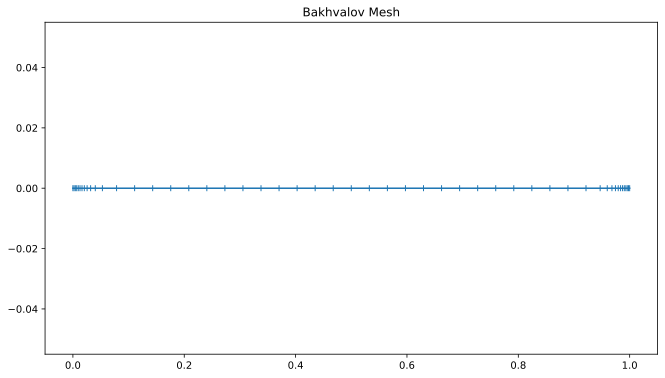

In [ ]:
# Form the 1D B mesh to compare

epsilon = 0.01
q = 1/4
sigma = 2.5
b = 1
a = sigma/b
tau = q-a*epsilon
error = 1


while error>1e-14:

  g2 = a*epsilon*(0.5-tau)-(0.5+a*epsilon*np.log(1-tau/q))*(q-tau)
  g2_tau = 1 + a*epsilon*np.log(1-tau/q)
  tau_new =tau-g2/g2_tau
  error = abs(tau-tau_new)
  tau=tau_new


if tau>0:

  phi = -a*epsilon*np.log(1-tau/q)
  phi_tau = a*epsilon/(q-tau)
  x_uni = np.linspace(0, 1, N+1)
  x_b = np.zeros(N+1)

  for i in range(1,int(N/2+1)):
    if x_uni[i]<tau:
      x_b[i] = -a*epsilon*np.log(1-x_uni[i]/q)
    else:
      x_b[i] = -a*epsilon*np.log(1-tau/q)+(x_uni[i]-tau)*phi_tau

  for i in range(int(N/2+1),N+1):
    x_b[i] = 1-x_b[N-i]


else:

  x_b = np.linspace(0, 1, N+1)


# Plot the result
plt.plot(x_b, [0 for i in range(N+1)], marker = "|")
plt.title('Bakhvalov Mesh')
plt.show()

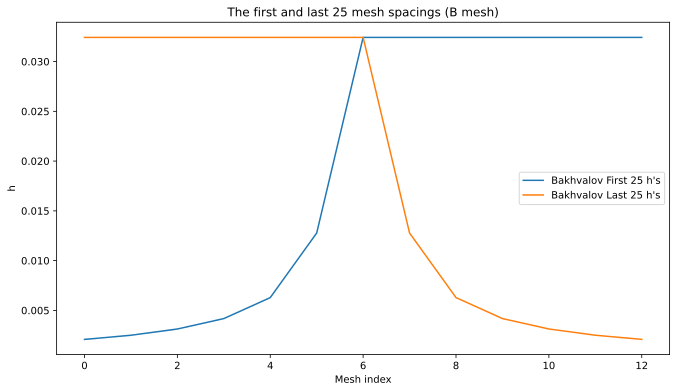

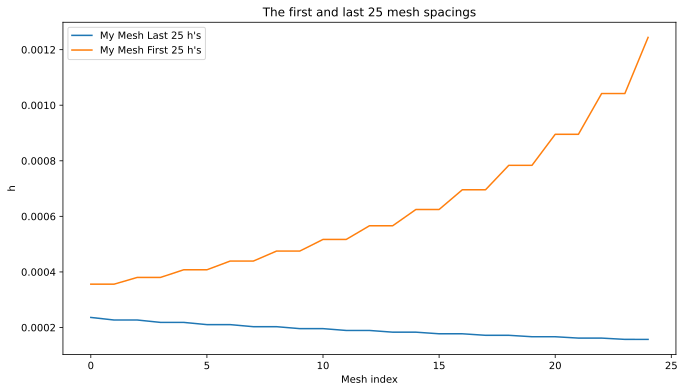

In [ ]:
# Plotting mesh differences
# plt.plot(np.diff(x_old.dat.data[permute_x])[-25:], label = "My Mesh Last 25 h's")
# plt.plot(np.diff(x_old.dat.data[permute_x])[0:25], label = "My Mesh First 25 h's")
plt.plot(np.diff(x_b)[0:25:2], label = "Bakhvalov First 25 h's")
plt.plot(np.diff(x_b)[-25::2], label = "Bakhvalov Last 25 h's")
plt.title("The first and last 25 mesh spacings (B mesh)")
plt.xlabel("Mesh index")
plt.ylabel("h")
plt.legend()
plt.show()

print()
print()

plt.plot(np.diff(x_old.dat.data[permute_x])[-25:], label = "My Mesh Last 25 h's")
plt.plot(np.diff(x_old.dat.data[permute_x])[0:25], label = "My Mesh First 25 h's")
# plt.plot(np.diff(x_b)[0:25], label = "Bakhvalov First 25 h's")
# plt.plot(np.diff(x_b)[-25:], label = "Bakhvalov Last 25 h's")
plt.title("The first and last 25 mesh spacings")
plt.xlabel("Mesh index")
plt.ylabel("h")
plt.legend()
plt.show()

In [ ]:
# # Compute L^2 and H^1 errors


# # exact u
# top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
# bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
# sub = exp(x)/(epsilon**2 - 1)
# u_exact = top/bottom - sub

# # Jacobian of x
# Jx = x.dx(0)


# # L^2 error
# error_val = (u - u_exact)
# L2_error = norm(error_val * (sqrt(abs(Jx))))
# print("L2 error is", L2_error)
# print()




# # H1 error
# # (\epsilon^2 || u' ||_0^2 + || u ||_0^2 ) ^{1/2}
# u_approx_pr = (1/Jx) * u.dx(0)
# u_exact_pr = (1/Jx) * u_exact.dx(0)
# u_pr_error = (u_approx_pr - u_exact_pr)
# L2_pr = norm(u_pr_error * (sqrt(abs(Jx))))
# H1_error =  float(sqrt( (epsilon**2) * (L2_pr**2) + (L2_error**2) ))
# print("H1 error is", H1_error)




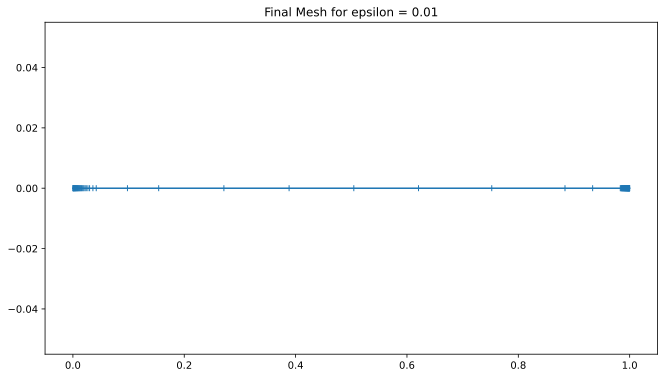

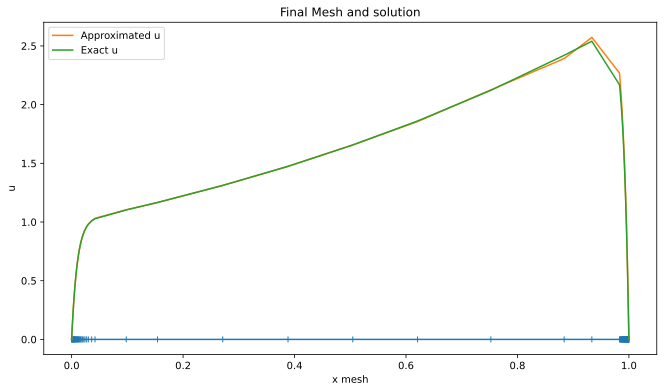



final alpha_tilda =  6.651124378805174


In [ ]:
# Plot the results


# exact u
top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x)/(epsilon**2 - 1)
u_exact = top/bottom - sub


# Just the mesh
# print final mesh
plt.plot(x.dat.data[permute_x], [0 for i in range(len(x.dat.data[permute_x]))], marker = "|")
plt.title("Final Mesh for epsilon = " + str(float(epsilon)))
plt.show()
print()
print()





# Solutions and Meshes

print()
plt.plot(x.dat.data[permute_x], np.zeros_like(x.dat.data[permute_x]), marker = "|")
plt.plot(x.dat.data[permute_x], u.dat.data[permute_x], label = "Approximated u")
plt.plot(x.dat.data[permute_x], Function(V).interpolate(u_exact).dat.data[permute_x], label = "Exact u")
plt.title("Final Mesh and solution")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()

print()
print()

print("final alpha_tilda = ", alpha_tilda.dat.data[:][0])